In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install einops flash_attn


import numpy as np # linear algebra
import pandas as pd # data processing
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw
import requests
import copy
from datasets import load_dataset
import os
import random
import matplotlib.pyplot as plt


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=186973264 sha256=a317a6656be86fa5f583be039c38408258633a21c9de5d5623e11486d6a5541c
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


2024-07-26 10:44:26.171571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 10:44:26.171680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 10:44:26.456143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the captions
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Exploring the dataset

In [6]:
keywords = ['dog', 'cat','person','guy','child','pet','friend']

df = pd.read_csv(CAPTIONS_PATH, delimiter="|")

df.dropna(subset=['image_name', ' comment'], inplace=True)

for keyword in keywords:
    print(df[df[' comment'].str.contains(keyword)])

            image_name  comment_number  \
60      1001773457.jpg               0   
61      1001773457.jpg               1   
62      1001773457.jpg               2   
63      1001773457.jpg               3   
64      1001773457.jpg               4   
...                ...             ...   
158825   989851184.jpg               0   
158826   989851184.jpg               1   
158827   989851184.jpg               2   
158828   989851184.jpg               3   
158829   989851184.jpg               4   

                                                  comment  
60       A black dog and a white dog with brown spots ...  
61       A black dog and a tri-colored dog playing wit...  
62       Two dogs of different breeds looking at each ...  
63        Two dogs on pavement moving toward each other .  
64             A black dog and a spotted dog are fighting  
...                                                   ...  
158825   A black dog has a dumbbell in his mouth looki...  
158826   A blac

## Showing 5 images from each category

Keyword: dog
        image_name  comment_number  \
60  1001773457.jpg               0   
61  1001773457.jpg               1   
62  1001773457.jpg               2   
63  1001773457.jpg               3   
64  1001773457.jpg               4   

                                              comment  
60   A black dog and a white dog with brown spots ...  
61   A black dog and a tri-colored dog playing wit...  
62   Two dogs of different breeds looking at each ...  
63    Two dogs on pavement moving toward each other .  
64         A black dog and a spotted dog are fighting  


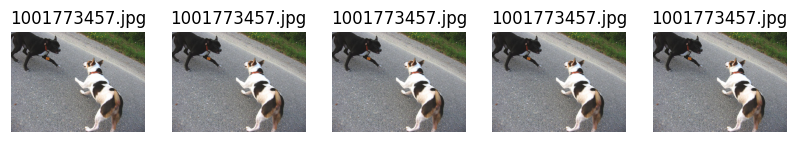

Keyword: cat
         image_name  comment_number  \
360  1019604187.jpg               0   
361  1019604187.jpg               1   
362  1019604187.jpg               2   
363  1019604187.jpg               3   
370  1020651753.jpg               0   

                                               comment  
360   A dog prepares to catch a thrown object in a ...  
361   A white dog is ready to catch a yellow ball f...  
362   A white dog is about to catch a yellow ball i...  
363   A white dog is about to catch a yellow dog toy .  
370   A white dog is trying to catch a ball in mida...  


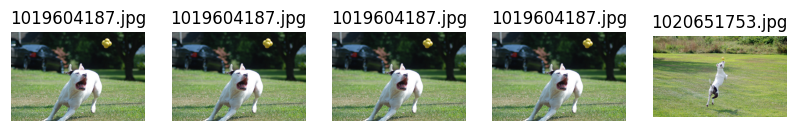

Keyword: person
        image_name  comment_number  \
100  100444898.jpg               0   
130  100716317.jpg               0   
131  100716317.jpg               1   
132  100716317.jpg               2   
183  101001624.jpg               3   

                                               comment  
100   A person in gray stands alone on a structure ...  
130   A person with long gray hair has a beret with...  
131   A person dressed in a blue coat is standing i...  
132   A person with gray hair is painting in a publ...  
183           A person riding a bike on a snowy road .  


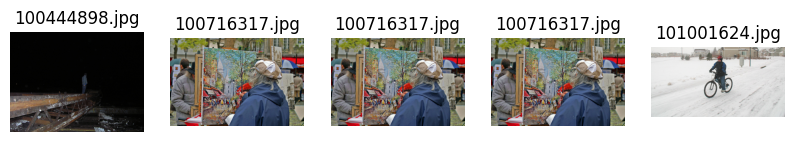

Keyword: guy
        image_name  comment_number  \
0   1000092795.jpg               0   
21  1000366164.jpg               1   
28  1000523639.jpg               3   
49  1001545525.jpg               4   
56  1001633352.jpg               1   

                                              comment  
0    Two young guys with shaggy hair look at their...  
21   Two guy cooking and joking around with the ca...  
28           a guy stitching up another man 's coat .  
49              two guys jumping over a gate together  
56   Four casually dressed guys jumping down a sta...  


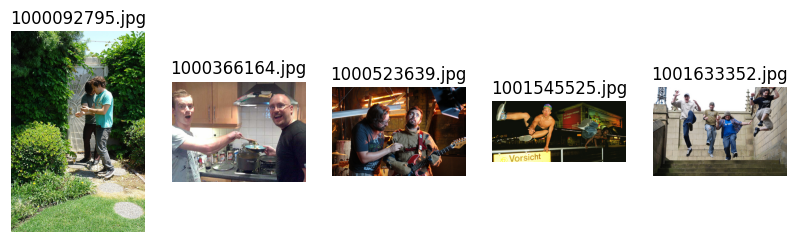

Keyword: child
         image_name  comment_number  \
10   1000268201.jpg               0   
115  1006452823.jpg               0   
116  1006452823.jpg               1   
117  1006452823.jpg               2   
140  1007320043.jpg               0   

                                               comment  
10    A child in a pink dress is climbing up a set ...  
115   two children , a girl and a boy are practicin...  
116   Two children sit on a small seesaw in the sand .  
117          Two children sitting on a teeter totter .  
140   A small child grips onto the red ropes at the...  


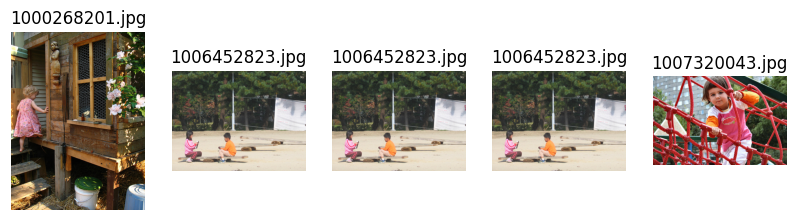

Keyword: pet
          image_name  comment_number  \
261    101362650.jpg               1   
467   1027211271.jpg               2   
820    105493628.jpg               0   
974   1065831604.jpg               4   
1143  1080230428.jpg               3   

                                                comment  
261    A boy jump kicking over three kids kicking wo...  
467    This person is performing a trick in skateboa...  
820    White wine and appetizers on are displayed in...  
974      Several bike riders compete in a competition .  
1143   Volleyball players compete on a sunny day at ...  


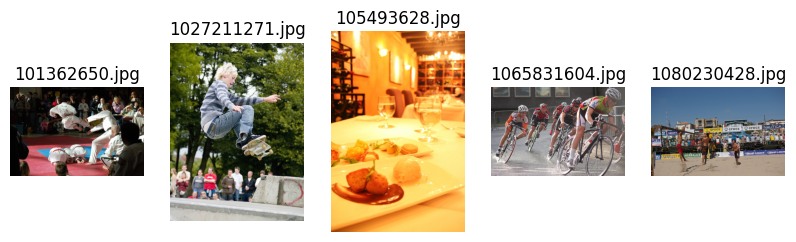

Keyword: friend
          image_name  comment_number  \
4     1000092795.jpg               4   
1350  1094283901.jpg               0   
1630  1106644976.jpg               0   
2283  1145781754.jpg               3   
2284  1145781754.jpg               4   

                                                comment  
4               Two friends enjoy time spent together .  
1350   A shirtless man jumping off a large concrete ...  
1630   A young group of friends adorned with face pa...  
2283       A group of friends converse around a table .  
2284           A group of friends talk around a table .  


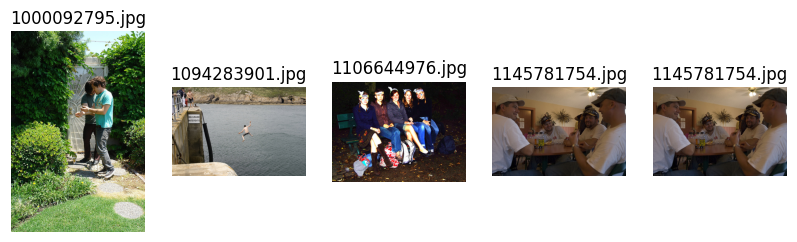

In [7]:
# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(image_paths):
        try:
            image = Image.open(image_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(os.path.basename(image_path))
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
    plt.show()

# Filter the DataFrame based on the keywords and display 5 images each
for keyword in keywords:
    filtered_records = df[df[' comment'].str.contains(keyword)].head(5)
    print(f"Keyword: {keyword}")
    print(filtered_records)

    # Get the image paths for the filtered records
    image_paths = [os.path.join(IMAGES_PATH, img_name.strip()) for img_name in filtered_records['image_name']]
    
    # Display the images
    display_images(image_paths)

In [8]:
# Clean up 'image_name' and ' comment' columns
df['image_name'] = df['image_name'].str.strip().str.lower()  # Ensure no extra spaces or case differences
df[' comment'] = df[' comment'].str.strip().str.lower()  # Normalize the comments

# Remove any potential non-printable characters
df['image_name'] = df['image_name'].apply(lambda x: ''.join(c for c in x if c.isprintable()))
df[' comment'] = df[' comment'].apply(lambda x: ''.join(c for c in x if c.isprintable()))

# Ensure image names have consistent extensions
df['image_name'] = df['image_name'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')


## **We see duplicates so lets remove and show again**

Duplicates before removal:
            image_name  comment_number  \
0       1000092795.jpg               0   
1       1000092795.jpg               1   
2       1000092795.jpg               2   
3       1000092795.jpg               3   
4       1000092795.jpg               4   
...                ...             ...   
158910   998845445.jpg               0   
158911   998845445.jpg               1   
158912   998845445.jpg               2   
158913   998845445.jpg               3   
158914   998845445.jpg               4   

                                                  comment  
0       two young guys with shaggy hair look at their ...  
1       two young , white males are outside near many ...  
2        two men in green shirts are standing in a yard .  
3            a man in a blue shirt standing in a garden .  
4                 two friends enjoy time spent together .  
...                                                   ...  
158910  a man in shorts and a hawaiian shirt lea

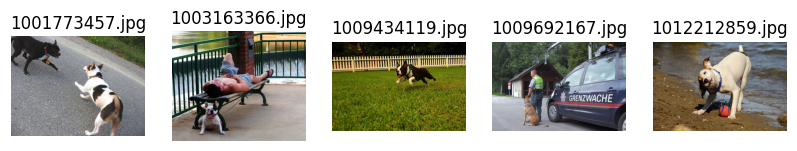

Keyword: cat


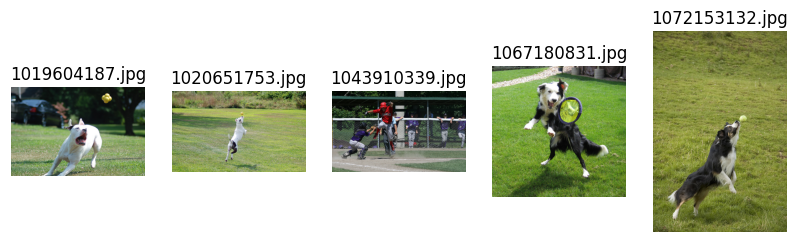

Keyword: person


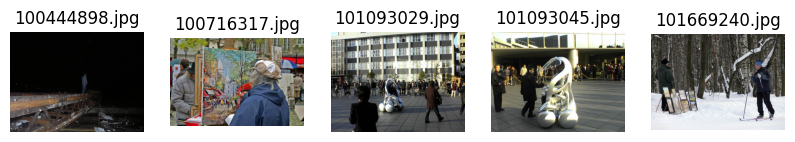

Keyword: guy


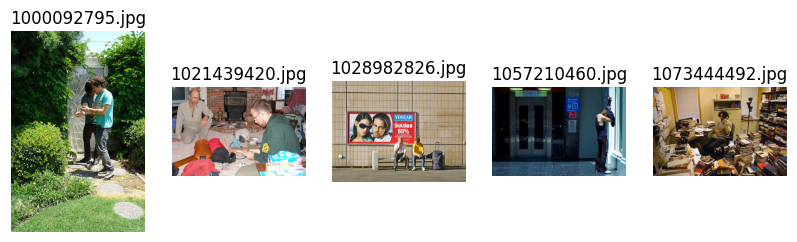

Keyword: child


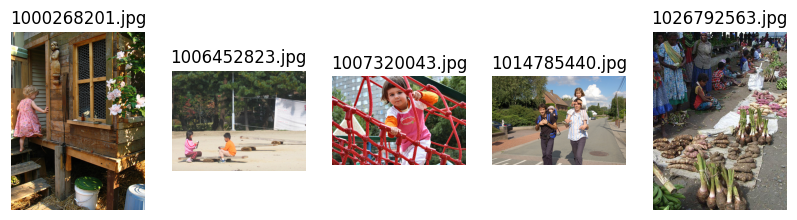

Keyword: pet


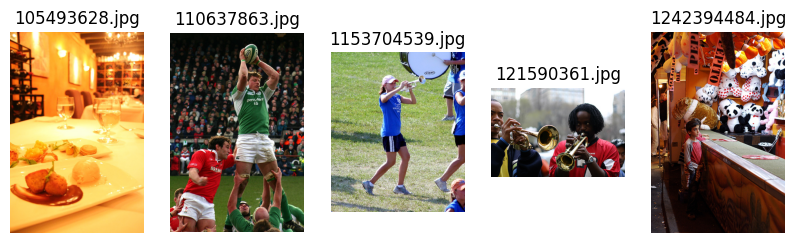

Keyword: friend


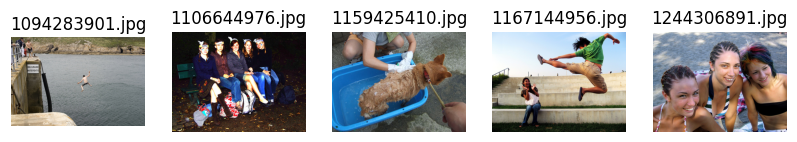

In [10]:
# Check for duplicates before removing
print("Duplicates before removal:")
print(df[df.duplicated(subset=['image_name'], keep=False)])

# Remove exact duplicates
df.drop_duplicates(subset=['image_name'], keep='first', inplace=True)

# Check for remaining duplicates
print("Duplicates after removal:")
print(df[df.duplicated(subset=['image_name'], keep=False)])

for keyword in keywords:
    filtered_records = df[df[' comment'].str.contains(keyword)].head(5)
    print(f"Keyword: {keyword}")
    
    # Get the image paths for the filtered records
    image_paths = [os.path.join(IMAGES_PATH, img_name.strip()) for img_name in filtered_records['image_name']]
    
    # Display the images
    display_images(image_paths)

In [12]:


    
# Add start and end tokens to each caption
df['comment'] = "<start> " + df[' comment'].str.strip() + " <end>"
    
# Remove captions that are either too short or too long
df['caption_length'] = df[' comment'].str.split().apply(len)
df = df[(df['caption_length'] >= 4) & (df['caption_length'] <= SEQ_LENGTH)]
df.drop(columns=['caption_length'], inplace=True)
    
# Create the full image path
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGES_PATH, x.strip()))
    
  
    
for keyword in keywords:
    # Filter records containing the keyword
    keyword_filtered_df = df[df[' comment'].str.contains(keyword, na=False)]

    # Ensure there are at least `min_records` records
    if len(keyword_filtered_df) >= 600:
            keyword_filtered_df = keyword_filtered_df.head(600)
        
    # Append to the result DataFrame
    df = pd.concat([df, keyword_filtered_df])

    # Print the number of records for the keyword
    print(f"Keyword: {keyword}")
    print(f"Number of records: {len(keyword_filtered_df)}")
    
    
# Ensure only necessary columns are kept
df = df[['image_path', ' comment']]
 

print(f"Total number of samples: {len(df)}")
for path in df["image_path"][:5]:
    print(path)

Keyword: dog
Number of records: 600
Keyword: cat
Number of records: 331
Keyword: person
Number of records: 600
Keyword: guy
Number of records: 214
Keyword: child
Number of records: 600
Keyword: pet
Number of records: 204
Keyword: friend
Number of records: 89
Total number of samples: 23477
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000268201.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000344755.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000366164.jpg


In [13]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = model.half() #ensure float16 presicion

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
min_object_size = (50, 50)  # Minimum size of bounding boxes
max_object_size = (300, 300)  # Maximum size of bounding boxes
min_image_size = (256, 256)  # Minimum size of images
max_image_size = (1024, 1024)  # Maximum size of images

def resize_image(image):
    # Resize the image to a size within the defined degrees of freedom
    image = image.resize((min(max(image.size[0], min_image_size[0]), max_image_size[0]),
                          min(max(image.size[1], min_image_size[1]), max_image_size[1])))
    return image

In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [ ]:
text_prompt = '<OD>'
image=Image.open("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg")
result=run_example(text_prompt)

result['<OD>']

In [ ]:
def create_annotations(image, comment, model, processor, device):
    # Process the image
    inputs = processor(images=image, return_tensors="pt")
    
    # Move image tensor to the device and convert to float16
    pixel_values = inputs['pixel_values'].to(device).half()
    
    # Process text
    text_inputs = processor(text=comment, return_tensors="pt")
    input_ids = text_inputs['input_ids'].to(device)
    attention_mask = text_inputs['attention_mask'].to(device)
    
    # Perform the forward pass with both image and text inputs
    outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
    
    # Extract bounding boxes and labels
    logits = outputs.logits
    bboxes = logits.softmax(-1).argmax(-1).tolist()
    labels = outputs.labels.tolist()
    
    return bboxes, labels

def filter_and_resize_annotations(bboxes, labels, min_object_size, max_object_size):
    filtered_bboxes = []
    filtered_labels = []
    
    for bbox, label in zip(bboxes, labels):
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        if min_object_size[0] <= width <= max_object_size[0] and min_object_size[1] <= height <= max_object_size[1]:
            filtered_bboxes.append(bbox)
            filtered_labels.append(label)
    
    return filtered_bboxes, filtered_labels


def get_comment_and_image_path(image_path):
    matching_rows = dataset[dataset['image_name'] == image_path]
    if matching_rows.empty:
        print(f"No matching entry for image path {image_path}")
        return None, None
    comments = matching_rows['comment'].tolist()[0]
    if comments:
        combined_comment = ' '.join(comments)  # Combine comments into a single string
        return combined_comment, filename
    else:
        return None, filename

def process_images_in_directory(directory, model, processor, device):
    annotations = []

    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.jpg'):  # Only process JPEG images
                # Get the base filename (e.g., '2715746315.jpg')
                image_filename = filename
                
                # Construct image path and check in dataset
                image_path = os.path.join(dirname, filename)
                
                # Extract just the filename from the image path in the dataset
                image_paths_from_dataset = dataset['image_path'].apply(lambda x: os.path.basename(x)).unique()
                
                # Check if the filename exists in the dataset
                if image_filename in image_paths_from_dataset:
                    # Find the row(s) in the dataset matching the filename
                    matching_rows = dataset[dataset['image_path'].apply(lambda x: os.path.basename(x)) == image_filename]

                    # Continue processing if necessary
                    image = Image.open(image_path)
                    image = resize_image(image)
                    # Call your object detection function or any other processing here
                    data = run_example('<OD>')
                    filtered_bboxes = []
                    filtered_labels = []

                    for bbox, label in zip(data['<OD>']['bboxes'], data['<OD>']['labels']):
                        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
                        if min_object_size[0] <= width <= max_object_size[0] and min_object_size[1] <= height <= max_object_size[1]:
                            filtered_bboxes.append(bbox)
                            filtered_labels.append(label)

                    annotations.append({'image_path': image_path, 'bboxes': filtered_bboxes, 'labels': filtered_labels})
     # Convert list to DataFrame
    annotations = pd.DataFrame(annotations, columns=['image_path', 'bboxes', 'labels'])
    return annotations



In [ ]:
# Directory containing the images
image_directory = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'


# Process all images in the directory to get annotations
annotations_df = process_images_in_directory(image_directory, model, processor, torch.device("cuda"))

#Save DataFrame to CSV
annotations_df.to_csv('annotations.csv', index=False)

def split_dataset(annotations, train_ratio=0.8):
    num_train = int(len(annotations) * train_ratio)
    random.shuffle(annotations)
    train_annotations = annotations[:num_train]
    val_annotations = annotations[num_train:]
    
    return train_annotations, val_annotations








In [ ]:
for annotat in annotations_df["image_path"][:5]:
    # Print the type and content of `annotat` to ensure it is a dictionary
    print(f"Type of annotat: {type(annotat)}")
    print(f"Content of annotat: {annotat}")

annotations_df.head(20)

In [ ]:
for annotat in annotations_df[:5]:
    image = Image.open(annotat['image_path'])
    plot_bbox(image, annotat)

In [ ]:

# Split dataset
train_annotations, val_annotations = split_dataset(annotation)

# Ensure there are enough images for each class (this may need to be adjusted based on your specific dataset and classes)
assert len([ann for ann in train_annotations if 'person' in ann['labels']]) >= 500
assert len([ann for ann in train_annotations if 'pet' in ann['labels']]) >= 500
assert len([ann for ann in val_annotations if 'person' in ann['labels']]) >= 100
assert len([ann for ann in val_annotations if 'pet' in ann['labels']]) >= 100


In [ ]:
def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
# Convert the annotations to a DataFrame and save to CSV
data = []
for anno in annotations_df:
    image_path = anno['image_path']
    bboxes = anno['bboxes']
    labels = anno['labels']
    
    
    for bbox, label in zip(bboxes, labels):
        x1, y1, x2, y2 = bbox
        data.append({
            'image_path': image_path,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'label': label
        })

df_annotations = pd.DataFrame(data)
df_annotations.to_csv('annotations.csv', index=False)